In [1]:
import yfinance as yf
ticker = input("Enter the Stock Symbol:")
stock = yf.Ticker(ticker)
stock_hist = stock.history(period="max")

In [2]:
import os
import pandas as pd

DATA_PATH = f"Data/{ticker}_stock_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        stock_hist = pd.read_json(DATA_PATH)
else:
    stock = yf.Ticker("MSFT")
    stock_hist = stock.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    stock_hist.to_json(DATA_PATH)

In [3]:
stock_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.054693,0.062736,0.054693,0.060055,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.060055,0.063272,0.060055,0.062199,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.062199,0.063808,0.062199,0.063272,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.063272,0.063808,0.061127,0.061663,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.061663,0.062199,0.060055,0.060591,47894400,0.0,0.0


<Axes: xlabel='Date'>

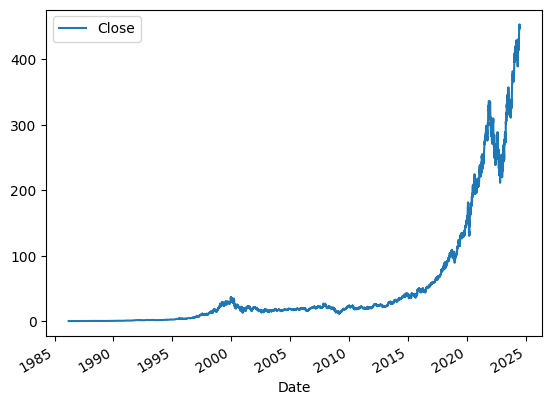

In [4]:
# Visualize microsoft stock prices
stock_hist.plot.line(y="Close", use_index=True)

In [5]:
# Ensure we know the actual closing price
data = stock_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = stock_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [6]:
data.head()

,Actual_Close,Target
Date,,
1986-03-13 00:00:00-05:00,0.060055,NaN
1986-03-14 00:00:00-05:00,0.062199,1.0
1986-03-17 00:00:00-05:00,0.063272,1.0
1986-03-18 00:00:00-05:00,0.061663,0.0
1986-03-19 00:00:00-05:00,0.060591,0.0


In [7]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
stock_prev = stock_hist.copy()
stock_prev = stock_prev.shift(1)

In [8]:
stock_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 00:00:00-05:00,0.054693,0.062736,0.054693,0.060055,1.031789e+09,0.0,0.0
1986-03-17 00:00:00-05:00,0.060055,0.063272,0.060055,0.062199,3.081600e+08,0.0,0.0
1986-03-18 00:00:00-05:00,0.062199,0.063808,0.062199,0.063272,1.331712e+08,0.0,0.0
1986-03-19 00:00:00-05:00,0.063272,0.063808,0.061127,0.061663,6.776640e+07,0.0,0.0


In [9]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(stock_prev[predictors]).iloc[1:]

In [10]:
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1986-03-14 00:00:00-05:00,0.062199,1.0,0.060055,1.031789e+09,0.054693,0.062736,0.054693
1986-03-17 00:00:00-05:00,0.063272,1.0,0.062199,3.081600e+08,0.060055,0.063272,0.060055
1986-03-18 00:00:00-05:00,0.061663,0.0,0.063272,1.331712e+08,0.062199,0.063808,0.062199
1986-03-19 00:00:00-05:00,0.060591,0.0,0.061663,6.776640e+07,0.063272,0.063808,0.061127
1986-03-20 00:00:00-05:00,0.058982,0.0,0.060591,4.789440e+07,0.061663,0.062199,0.060055


In [11]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

In [12]:
# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [13]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5257731958762887

<Axes: xlabel='Date'>

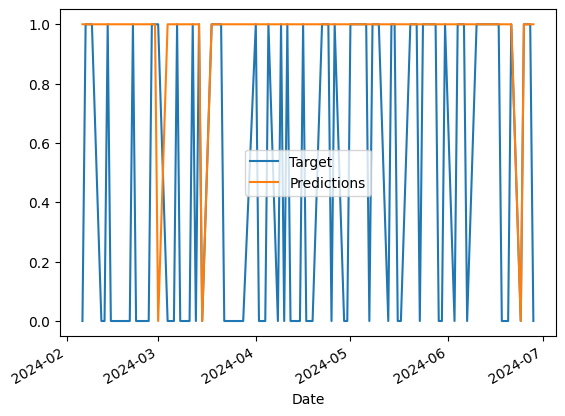

In [14]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

In [15]:
i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

In [16]:
preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

In [17]:
preds.head()

Date
1990-02-27 00:00:00-05:00    1.0
1990-02-28 00:00:00-05:00    1.0
1990-03-01 00:00:00-05:00    1.0
1990-03-02 00:00:00-05:00    1.0
1990-03-05 00:00:00-05:00    1.0
dtype: float64

In [18]:
predictions = []
# Loop over the dataset in increments
for i in range(1000, data.shape[0], step):
    # Split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()

    # Fit the random forest model
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[preds > .6] = 1
    preds[preds<=.6] = 0

    # Combine predictions and test values
    combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

    predictions.append(combined)

In [19]:
predictions[0].head()

,Target,Predictions
Date,,
1990-02-27 00:00:00-05:00,0.0,1.0
1990-02-28 00:00:00-05:00,1.0,1.0
1990-03-01 00:00:00-05:00,1.0,1.0
1990-03-02 00:00:00-05:00,1.0,1.0
1990-03-05 00:00:00-05:00,1.0,1.0


In [20]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

In [21]:
predictions = backtest(data, model, predictors)

In [22]:
predictions["Predictions"].value_counts()

Predictions
0.0    7891
1.0     759
Name: count, dtype: int64

In [23]:
predictions["Target"].value_counts()

Target
1.0    4392
0.0    4258
Name: count, dtype: int64

In [24]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5125164690382081

In [25]:
weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

In [26]:
weekly_trend = data.shift(1).rolling(7).sum()["Target"]

In [27]:
data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

In [28]:
data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

In [29]:
data["weekly_trend"] = weekly_trend

In [30]:
data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [31]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio","low_close_ratio"]

In [32]:
predictions = backtest(data.iloc[365:], model, full_predictors)

In [33]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5730659025787965

In [34]:
# Show how many trades we would make

predictions["Predictions"].value_counts()

Predictions
0.0    7936
1.0     349
Name: count, dtype: int64

<Axes: xlabel='Date'>

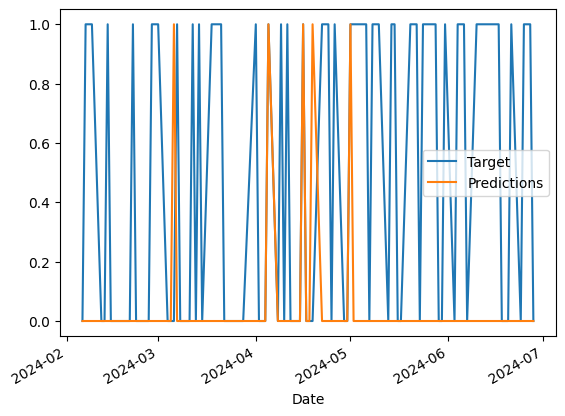

In [35]:
# Look at trades we would have made in the last 100 days

predictions.iloc[-100:].plot()